## Desafio de Análise de Dados: Empréstimos de Acervos das Bibliotecas da UFRN

Neste desafio do #7DaysOfCode, o objetivo é analisar os dados de empréstimos dos acervos do sistema de bibliotecas da UFRN, utilizando as ferramentas do Python como o Pandas. A partir dessa análise, será possível extrair insights valiosos sobre o comportamento dos empréstimos ao longo dos últimos anos, identificar padrões e formular hipóteses para melhorar a gestão e os processos das bibliotecas.

A análise exploratória de dados (EDA) será a principal metodologia utilizada. A EDA é fundamental para compreender as tendências nos dados, explorar informações sobre os processos, usuários e recursos das bibliotecas, além de gerar novas perguntas que podem orientar decisões mais assertivas na gestão do acervo. Durante o processo, vamos focar em questões como:

A quantidade de empréstimos tem aumentado ou diminuído ao longo dos anos?

Quais bibliotecas apresentam o maior número de empréstimos?

Quais são os temas mais e menos requisitados pelos usuários?

Para atingir esses objetivos, o trabalho será dividido em várias etapas, desde a coleta e transformação dos dados até a criação de visualizações e a exportação de tabelas para um formato utilizável em diferentes contextos. O Pandas será utilizado para importar dados de diferentes fontes, realizar transformações necessárias e, por fim, gerar insights que possam ser apresentados de forma clara e eficaz.

Com esses dados, será possível entender melhor o funcionamento do sistema de bibliotecas e fornecer informações para tomadas de decisão mais informadas, visando melhorar a experiência dos usuários e a utilização dos recursos disponíveis.


In [1]:
# Instalação das bibliotecas necessárias
%pip install pandas
%pip install fastparquet
%pip install seaborn
%pip install matplotlib
%pip install plotly
%pip install numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [125]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Coletando os dados de empréstimos (2010 a 2020)

In [3]:
anos = range(2010, 2021)
semestres = [1, 2]
arquivos = []

for ano in anos:
    for semestre in semestres:
        if ano == 2020 and semestre == 2:
            continue  # Esse arquivo não existe
        url = f"https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-{ano}{semestre}.csv?raw=true"
        try:
            df = pd.read_csv(url)
            arquivos.append(df)
        except Exception as e:
            print(f"Erro ao carregar {url}: {e}")

Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-20101.csv?raw=true: HTTP Error 429: Too Many Requests
Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-20132.csv?raw=true: HTTP Error 429: Too Many Requests
Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-20172.csv?raw=true: HTTP Error 429: Too Many Requests


### Concatenando os DataFrames

In [4]:
emprestimos = pd.concat(arquivos, ignore_index=True)

### Verificando Duplicatas

In [5]:
duplicatas = emprestimos[emprestimos.duplicated()]
print(f"Total de duplicatas encontradas: {len(duplicatas)}")

Total de duplicatas encontradas: 19


### Excluindo Duplicatas

In [6]:
emprestimos = emprestimos.drop_duplicates()

In [7]:
# Exibindo as primeiras linhas do DataFrame
emprestimos.head(10)

,id_emprestimo,codigo_barras,data_renovacao,data_emprestimo,data_devolucao,matricula_ou_siape,tipo_vinculo_usuario
0,799100,S025602_19/11/2013 10:51:34,NaN,2010/07/01 07:45:41.111000000,2010/07/07 10:52:31.000000000,2.009050e+09,ALUNO DE GRADUAÇÃO
1,799101,2008049500,NaN,2010/07/01 08:08:17.690000000,2010/07/01 09:03:44.000000000,2.010056e+09,ALUNO DE GRADUAÇÃO
2,799102,X008043,NaN,2010/07/01 08:13:31.574000000,2010/07/09 15:14:44.000000000,2.009043e+09,ALUNO DE GRADUAÇÃO
3,799103,2009055438,2010/07/14 18:35:35.042000000,2010/07/01 08:22:46.085000000,2010/07/29 14:59:16.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO
4,799104,S024636,2010/07/16 21:29:43.569000000,2010/07/01 08:40:28.512000000,2010/07/28 07:49:32.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO
5,799105,2009052639,2010/07/16 21:29:43.553000000,2010/07/01 08:40:28.552000000,2010/07/28 07:49:08.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO
6,799106,S023100,2010/07/16 21:29:43.535000000,2010/07/01 08:40:28.583000000,2010/07/28 07:49:52.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO
7,799107,X008049,2010/07/16 14:04:20.580000000,2010/07/01 08:48:18.120000000,2010/08/02 13:44:54.000000000,2.010052e+09,ALUNO DE GRADUAÇÃO
8,799108,2006040166,2010/07/15 23:15:03.613000000,2010/07/01 08:48:25.039000000,2010/07/29 08:17:34.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO
9,799109,2006040218,2010/07/15 23:15:03.601000000,2010/07/01 08:48:25.082000000,2010/07/29 08:18:01.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO


### Importando os Dados de exemplares

In [8]:
dados_exemplares = pd.read_parquet('https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/raw/main/Dia_1-Importando_dados/Datasets/dados_exemplares.parquet')
dados_exemplares

,id_exemplar,codigo_barras,colecao,biblioteca,status_material,localizacao,registro_sistema
index,,,,,,,
0,5,L000003,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,694,1
1,4,L000002,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,688,1
2,3,L000001,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,638,1
3,7,L000114,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,616,5
5,10,L000041,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,657,15
...,...,...,...,...,...,...,...
568580,1353472,2021011150,Acervo Circulante,Biblioteca Setorial do Núcleo de Educação da I...,REGULAR,951,268231
568581,1353473,2019013454,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,997,268233
568582,1353474,2019012811,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,987,268234


In [9]:
todos_emprestimos = emprestimos.merge(dados_exemplares, on="codigo_barras", how="inner")
todos_emprestimos.head()

,id_emprestimo,codigo_barras,data_renovacao,data_emprestimo,data_devolucao,matricula_ou_siape,tipo_vinculo_usuario,id_exemplar,colecao,biblioteca,status_material,localizacao,registro_sistema
0,799100,S025602_19/11/2013 10:51:34,NaN,2010/07/01 07:45:41.111000000,2010/07/07 10:52:31.000000000,2.009050e+09,ALUNO DE GRADUAÇÃO,186525,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,635,71668
1,799101,2008049500,NaN,2010/07/01 08:08:17.690000000,2010/07/01 09:03:44.000000000,2.010056e+09,ALUNO DE GRADUAÇÃO,184388,Acervo Circulante,Biblioteca Setorial Prof. Francisco Gurgel De ...,REGULAR,694,70925
2,799102,X008043,NaN,2010/07/01 08:13:31.574000000,2010/07/09 15:14:44.000000000,2.009043e+09,ALUNO DE GRADUAÇÃO,161925,Acervo Circulante,Biblioteca Setorial Prof. Ronaldo Xavier de Ar...,REGULAR,613,60177
3,799103,2009055438,2010/07/14 18:35:35.042000000,2010/07/01 08:22:46.085000000,2010/07/29 14:59:16.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO,286093,Acervo Circulante,Biblioteca Setorial do Centro Ciências da Saúd...,REGULAR,690,125251
4,799104,S024636,2010/07/16 21:29:43.569000000,2010/07/01 08:40:28.512000000,2010/07/28 07:49:32.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO,158723,Acervo Circulante,Biblioteca Setorial do Centro Ciências da Saúd...,REGULAR,637,58978


### Verificando a estrutura do DataFrame

In [10]:
todos_emprestimos.dtypes

id_emprestimo             int64
codigo_barras            object
data_renovacao           object
data_emprestimo          object
data_devolucao           object
matricula_ou_siape      float64
tipo_vinculo_usuario     object
id_exemplar               int64
colecao                  object
biblioteca               object
status_material          object
localizacao               int64
registro_sistema          int64
dtype: object

### Criando a coluna "CDU" com base na classificação da localização


In [11]:
def classificar_CDU(valor):
    if valor < 100:
        return 'Generalidades, Ciência e Conhecimento'
    elif valor < 200:
        return 'Filosofia e Psicologia'
    elif valor < 300:
        return 'Religião'
    elif valor < 400:
        return 'Ciências sociais'
    elif valor < 500:
        return 'Classe vaga'
    elif valor < 600:
        return 'Matemática e Ciências Naturais'
    elif valor < 700:
        return 'Ciências aplicadas'
    elif valor < 800:
        return 'Belas Artes'
    elif valor < 900:
        return 'Linguagem'
    else:
        return 'Geografia, Biografia e História'

todos_emprestimos['CDU'] = todos_emprestimos['localizacao'].apply(classificar_CDU)
todos_emprestimos.head()


,id_emprestimo,codigo_barras,data_renovacao,data_emprestimo,data_devolucao,matricula_ou_siape,tipo_vinculo_usuario,id_exemplar,colecao,biblioteca,status_material,localizacao,registro_sistema,CDU
0,799100,S025602_19/11/2013 10:51:34,NaN,2010/07/01 07:45:41.111000000,2010/07/07 10:52:31.000000000,2.009050e+09,ALUNO DE GRADUAÇÃO,186525,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,635,71668,Ciências aplicadas
1,799101,2008049500,NaN,2010/07/01 08:08:17.690000000,2010/07/01 09:03:44.000000000,2.010056e+09,ALUNO DE GRADUAÇÃO,184388,Acervo Circulante,Biblioteca Setorial Prof. Francisco Gurgel De ...,REGULAR,694,70925,Ciências aplicadas
2,799102,X008043,NaN,2010/07/01 08:13:31.574000000,2010/07/09 15:14:44.000000000,2.009043e+09,ALUNO DE GRADUAÇÃO,161925,Acervo Circulante,Biblioteca Setorial Prof. Ronaldo Xavier de Ar...,REGULAR,613,60177,Ciências aplicadas
3,799103,2009055438,2010/07/14 18:35:35.042000000,2010/07/01 08:22:46.085000000,2010/07/29 14:59:16.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO,286093,Acervo Circulante,Biblioteca Setorial do Centro Ciências da Saúd...,REGULAR,690,125251,Ciências aplicadas
4,799104,S024636,2010/07/16 21:29:43.569000000,2010/07/01 08:40:28.512000000,2010/07/28 07:49:32.000000000,2.009054e+09,ALUNO DE GRADUAÇÃO,158723,Acervo Circulante,Biblioteca Setorial do Centro Ciências da Saúd...,REGULAR,637,58978,Ciências aplicadas


### Excluindo a coluna "registro_sistema" do DataFrame

In [12]:
todos_emprestimos.drop('registro_sistema', axis=1, inplace=True)
todos_emprestimos.columns

Index(['id_emprestimo', 'codigo_barras', 'data_renovacao', 'data_emprestimo',
       'data_devolucao', 'matricula_ou_siape', 'tipo_vinculo_usuario',
       'id_exemplar', 'colecao', 'biblioteca', 'status_material',
       'localizacao', 'CDU'],
      dtype='object')

### Transformando a coluna "matricula_ou_siape" para o tipo string

In [13]:
todos_emprestimos['matricula_ou_siape'] = todos_emprestimos['matricula_ou_siape'].astype(str)
todos_emprestimos['matricula_ou_siape'].dtypes

dtype('O')

### Relação entre empréstimo e empréstimo de exemplar

In [14]:
todos_emprestimos['id_emprestimo'].value_counts()

id_emprestimo
2049407    3
1775991    3
2010326    3
2014596    3
2422542    3
          ..
799121     1
799122     1
799123     1
799124     1
2989090    1
Name: count, Length: 1771236, dtype: int64

### Total de empréstimos e empréstimo de exemplares

In [15]:
qtd_emprestimos = todos_emprestimos['id_emprestimo'].nunique()
print(f"Quantidade total de empréstimos: {qtd_emprestimos}")
qtd_exemplares = len(todos_emprestimos)
print(f"Quantidade total de exemplares: {qtd_exemplares}")

Quantidade total de empréstimos: 1771236
Quantidade total de exemplares: 1774599


### Total de exemplares emprestados por ano

In [16]:
data_emprestimos = pd.DataFrame(todos_emprestimos['data_emprestimo'].value_counts()).reset_index()
data_emprestimos.columns = ['data','quantidade']
data_emprestimos['data'] = pd.to_datetime(data_emprestimos['data'])
data_emprestimos

,data,quantidade
0,2014-07-14 15:35:51.822,3
1,2014-01-28 14:49:50.505,3
2,2016-04-20 21:07:44.036,3
3,2015-05-05 20:37:19.551,3
4,2015-08-18 19:11:08.653,3
...,...,...
1771202,2010-07-01 09:16:46.713,1
1771203,2010-07-01 09:16:46.748,1
1771204,2010-07-01 09:16:46.786,1
1771205,2010-07-01 09:16:46.822,1


### Funções para agrupar por período e plotar o gráfico

In [139]:
def agrupar_por_periodo(df, coluna_data, coluna_valor, periodo):

    if not pd.api.types.is_datetime64_any_dtype(df[coluna_data]):
        df = df.copy()
        df[coluna_data] = pd.to_datetime(df[coluna_data])
    
    if periodo == 'month':
        resultado = df.groupby(df[coluna_data].dt.month)[coluna_valor].sum()
        meses = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'Mai', 6:'Jun', 
                7:'Jul', 8:'Ago', 9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}
        resultado.index = resultado.index.map(meses)
        resultado.index.name = 'mês'
    elif periodo == 'year':
        resultado = df.groupby(df[coluna_data].dt.year)[coluna_valor].sum()
        resultado.index.name = 'anos'
    elif periodo == 'hour':
        resultado = df.groupby(df[coluna_data].dt.hour)[coluna_valor].sum()
        resultado.index = [f"{h:02d}h" for h in resultado.index]
        resultado.index.name = 'hora'
    
    return resultado


def plotar_grafico(dados, titulo, tipo='line'):
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if tipo == 'line':
        sns.lineplot(x=dados.index, y=dados.values, marker='o', linewidth=2, color='#1f77b4', ax=ax)          
    else:
        sns.barplot(x=dados.index, y=dados.values, hue=dados.index, palette='colorblind', ax=ax, legend=False)

    
    if dados.index.name == 'anos':
        ax.set_xticks(dados.index)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(titulo, fontsize=14, fontweight='bold')
        
    elif dados.index.name == 'mês':
        ax.set_xticks(range(len(dados.index)))
        ax.set_xticklabels(dados.index, rotation=45, ha='right')
        ax.set_title(titulo, fontsize=14, fontweight='bold')

    else:
        ax.set_xticks(range(len(dados.index)))
        ax.set_title(titulo, fontsize=16, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout()
    return fig, ax        


### Análise por ano

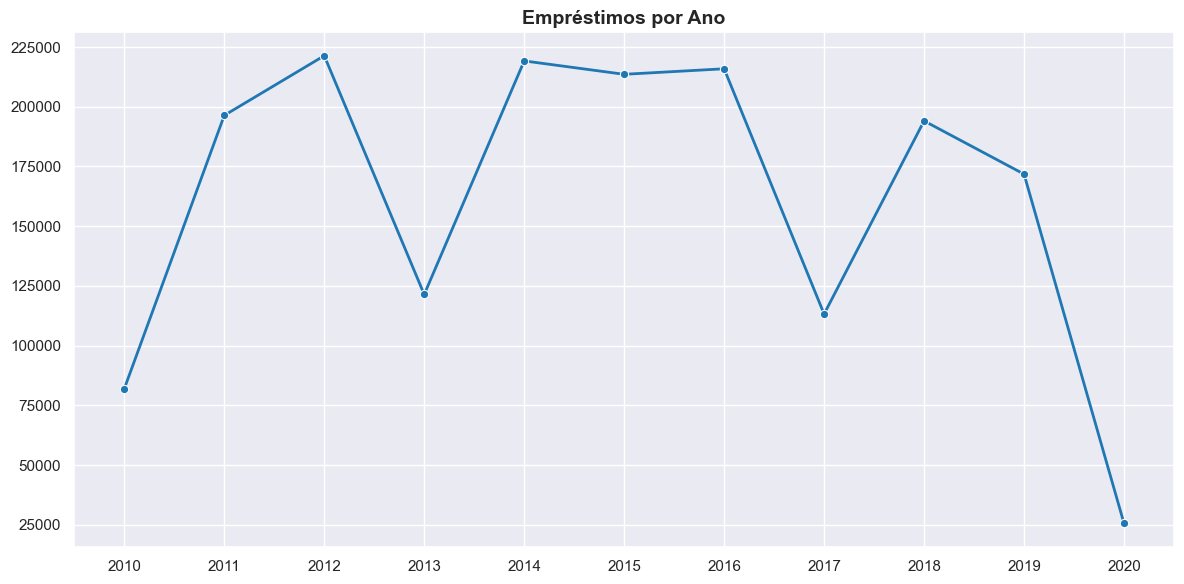

In [140]:
emprestimo_ano = agrupar_por_periodo(data_emprestimos, 'data', 'quantidade', 'year')
fig_ano, ax_ano = plotar_grafico(emprestimo_ano, 'Empréstimos por Ano', tipo='line')


A análise mostra que desde 2013 o número de exemplares emprestados vem diminuindo de forma contínua, com uma queda significativa já em 2019. O gráfico mostra que, após o pico de mais de 230 mil empréstimos em 2013, houve uma leve redução em 2014, certa estabilidade até 2017, e então uma queda mais acentuada em 2018 e 2019. Já o ano de 2020 apresentou uma quantidade de empréstimos muito inferior aos anos anteriores, mas não pode ser avaliado da mesma forma devido à diferença no volume de dados disponíveis para esse período.

É importante que a direção da biblioteca investigue com mais profundidade o que está ocorrendo desde 2013, revisando os procedimentos e buscando entender os fatores que contribuíram para essa redução. Algumas perguntas importantes que podem orientar análises futuras:

* O número de alunos da universidade vem diminuindo?

* A biblioteca está aplicando alguma pesquisa de satisfação com os usuários? Como estão os resultados?

* O acervo está atualizado e atrativo para os estudantes e pesquisadores?

* Quais estratégias de divulgação e marketing estão sendo realizadas para incentivar o uso da biblioteca?

* O que ocorreu de diferente em 2017 em comparação com 2015 e 2016, que pode ter contribuído para uma leve recuperação nos números?

*E em 2019? Houve alguma mudança estrutural, de política ou de atendimento?

### Análise por mês

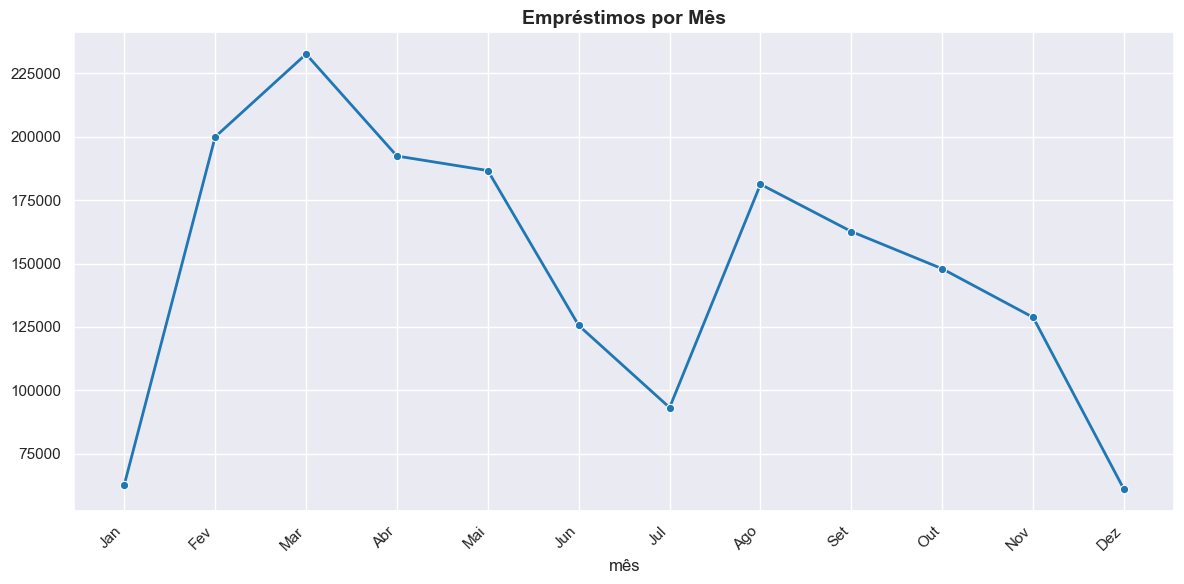

In [141]:
emprestimo_mes = agrupar_por_periodo(data_emprestimos , 'data', 'quantidade', 'month')
fig_mes, ax_mes = plotar_grafico(emprestimo_mes, 'Empréstimos por Mês', tipo='line')

Nota-se que os maiores volumes de empréstimos acontecem nos meses de março e agosto, o que faz bastante sentido considerando que são meses de início de semestre nas universidades.

Já os meses de janeiro, julho e dezembro apresentam os menores números, o que provavelmente está relacionado às férias acadêmicas. Isso não surpreende, mas é importante considerar que mesmo nesses períodos o funcionamento da biblioteca precisa ser garantido. Por isso, é essencial pensar no revezamento das equipes, evitando que todos tirem férias ao mesmo tempo, especialmente em janeiro, quando podem ser feitas atividades como inventário do acervo ou manutenção geral.

Os meses de maio, junho, outubro e novembro, que têm movimentação intermediária, podem ser bem aproveitados pela gestão para treinamentos, eventos internos ou pequenas reformas, sem impactar tanto o fluxo de usuários.

Chama atenção a queda expressiva em junho, o que merece uma investigação mais aprofundada. Pode haver algum fator pontual interferindo, como greves, calendário acadêmico alterado ou mesmo eventos que diminuem o interesse pelo uso da biblioteca nesse período.

Uma boa sugestão seria planejar ações específicas de incentivo ao uso da biblioteca antes das férias, como campanhas para empréstimo de livros para leitura em casa, desafios de leitura ou até divulgação especial nas redes sociais.

Essas ações podem ajudar a equilibrar o fluxo ao longo do ano e manter a biblioteca sempre presente na rotina dos estudantes.

### Análise por hora

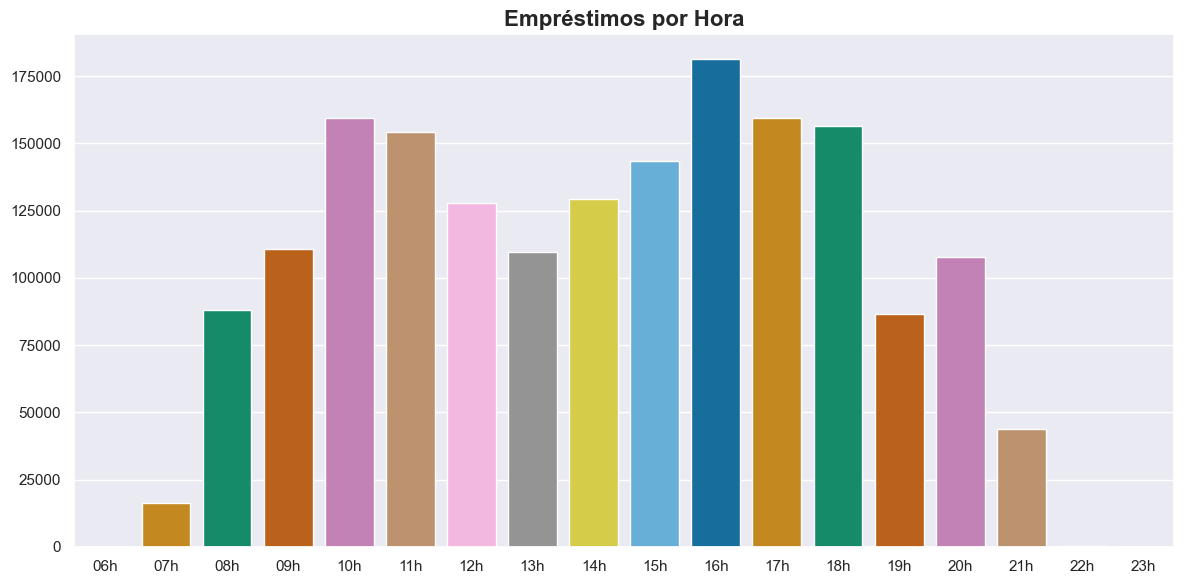

In [142]:
emprestimo_hora = agrupar_por_periodo(data_emprestimos, 'data', 'quantidade', 'hour')
fig_hora, ax_hora = plotar_grafico(emprestimo_hora, 'Empréstimos por Hora', tipo='bar')

Baseado no gráfico, vejo que há um pico significativo no atendimento de empréstimos durante as 10 h e 16 h, que são os horários de maior demanda. Isso indica que esses períodos podem exigir mais pessoal ou recursos para lidar com a demanda intensa. Além disso, pode ser interessante focar na melhoria do processo de atendimento nesses horários de pico para otimizar a eficiência.

Por outro lado, os períodos mais tranquilos, entre 7h e 9h da manhã e 19h a 22h, são ideais para realizar atividades que não dependem tanto da interação direta com os clientes, como atualização de registros, organização dos empréstimos ou planejamento das próximas etapas. Aproveitar esses horários de menor movimento pode ajudar a manter o fluxo de trabalho equilibrado ao longo do dia e garantir que as operações se mantenham eficientes.